In [1]:
import pickle as pkl
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
from glob import glob

In [2]:
spline_fs = glob("/Users/jlazar/research/TauRunner/taurunner/resources/cross_section_tables/CSMS_*dsde*.pkl")

In [9]:
out

array([[-59.28969759, -59.28205841, -59.27419713, ..., -61.74656021,
        -61.74696622, -61.74735678],
       [-59.28969759, -59.28205841, -59.27419713, ..., -61.74656021,
        -61.74696622, -61.74735678],
       [-59.28969759, -59.28205841, -59.27419713, ..., -61.74656021,
        -61.74696622, -61.74735678],
       ...,
       [-52.98016365, -52.93698964, -52.89302855, ..., -43.40495908,
        -43.40225505, -43.39965219],
       [-52.91485803, -52.87160858, -52.82746218, ..., -43.1794402 ,
        -43.17664158, -43.17394764],
       [-52.84986616, -52.8064713 , -52.7622584 , ..., -42.95379162,
        -42.95089724, -42.94811114]])

In [11]:
plot = False

ein = np.logspace(1, 10, 91) * 1e9
lein = np.log(ein)
zz = (1 - np.logspace(-5, 0, 300))[::-1]

out = np.zeros((len(lein), len(zz)))

for spline_f in spline_fs:
    name = spline_f.split("/")[-1].replace(".pkl", ".txt")
    print(name)
    with open(spline_f, "rb") as pkl_f:
        spl = pkl.load(pkl_f)
    zz = (1 - np.logspace(-5, 0, 300))[::-1]
    ein = np.logspace(1, 10, 91) * 1e9
    lein = np.log(ein)
    zz = (1 - np.logspace(-5, 0, 300))[::-1]


    for i, le in enumerate(lein):
        for j, z in enumerate(zz):
            out[i, j] = spl(le, z)

    if plot:
        for i, e in enumerate(ein):
            plt.plot(zz*(e-1e9)+1e9, np.exp(out[i]) /50677.3093741**2/(e/1e9), label=e/1e9)
            if i % 10 == 9:
                plt.loglog()
                plt.legend()
                plt.show()
    plt.show()
    
#     with open(f"/Users/jlazar/research/TAMBO-MC/resources/cross_sections/tables/{name}", "w") as file:
#          for row in out:
#             np.savetxt(file, row,fmt="%s")
    np.savetxt(f"/Users/jlazar/research/TAMBO-MC/resources/cross_sections/tables/{name}", out, newline="\n", delimiter="\t")
        

CSMS_nubar_n_dsde_CC.txt
CSMS_nubar_n_dsde_NC.txt
CSMS_nu_p_dsde_CC.txt
CSMS_nu_p_dsde_NC.txt
CSMS_nubar_p_dsde_NC.txt
CSMS_nubar_p_dsde_CC.txt
CSMS_nu_n_dsde_NC.txt
CSMS_nu_n_dsde_CC.txt


In [55]:
ein = 1e18
eout = 9.9999999e16
z = (ein-1e9)/(eout-1e9)
zz = (1 - np.logspace(-5, 0, 300))[::-1]
np.exp(spl(np.log(ein), z))/50677.3093741**2/(ein/1e9)

array([[2.52496345e-39]])

In [71]:
ein = np.logspace(1, 10, 91) * 1e9
lein = np.log(ein)
zz = (1 - np.logspace(-5, 0, 300))[::-1]
out = np.zeros((len(lein), len(zz)))

for i, le in enumerate(lein):
    for j, z in enumerate(zz):
        out[i, j] = spl(le, z)

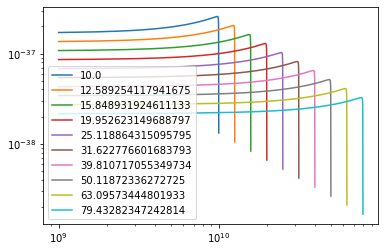

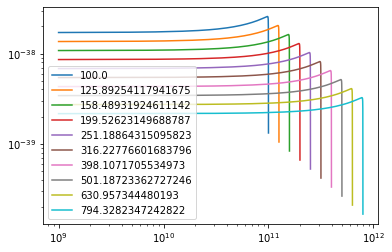

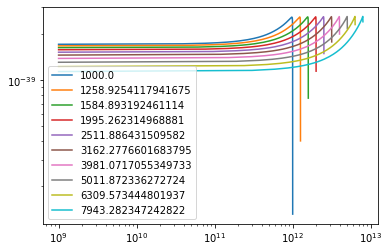

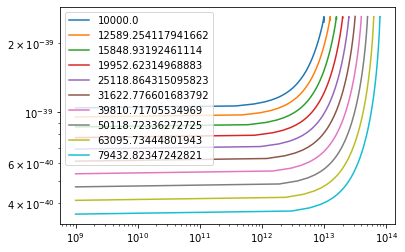

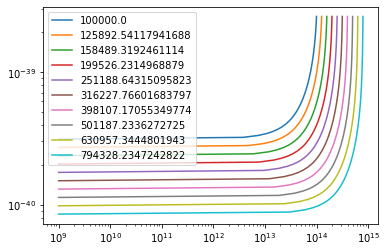

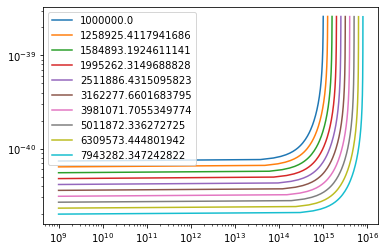

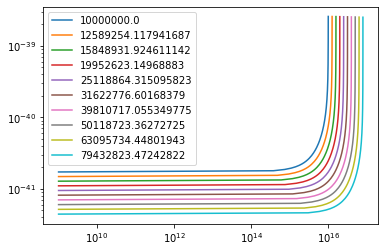

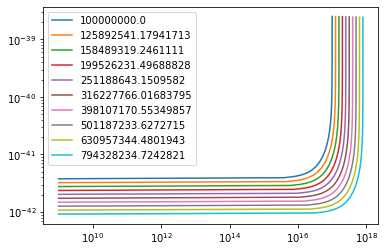

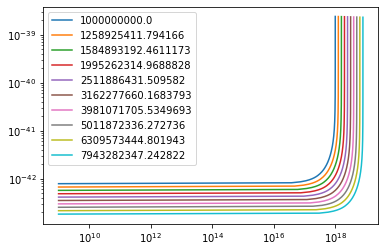

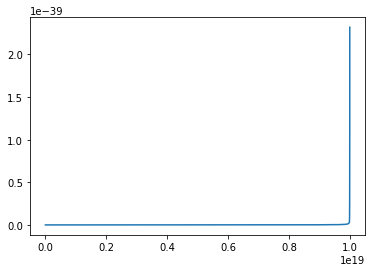

In [72]:
for i, e in enumerate(ein):
    plt.plot(zz*(e-1e9)+1e9, np.exp(out[i]) /50677.3093741**2/(e/1e9), label=e/1e9)
    if i % 10 == 9:
        plt.loglog()
        plt.legend()
        plt.show()